In [1]:
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA
import copy

import gab

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import multiprocessing
import glob
shootingDate = pandas.Timestamp('2018-10-27')
word2vecFiles = sorted(glob.glob('../2019-03-17-word2vec_2/?????*-hs_1*.pd'))

before_path ="../scripts/word_models/2019-03-17-before-after/before-hs_0-window_10-size_300-sample_0.01.pd"
after_path ="../scripts/word_models/2019-03-17-before-after/after-hs_0-window_10-size_300-sample_0.01.pd"

targetWord2Vec = '../users_info_word2vec_2/full-hs_1-window_10-size_300-sample_0.01.pd'

kaggle_word_counts = './unigram_freq.csv'
reddit_word_counts = '../scripts/word_models/reddit_2017-11_ngrams/1-grams.csv'

reddit_w2v_path = '../reddit/RC_2018-11-w2v/full-hs_0-window_10-size_300-sample_0.01.pd'

googleWord2Vec = '../GoogleNews-vectors-negative300.bin.gz'

In [2]:
w2v_before = gensim.models.Word2Vec.load(before_path)
w2v_after = gensim.models.Word2Vec.load(after_path)

In [3]:
w2v_reddit = gensim.models.Word2Vec.load(reddit_w2v_path)

In [4]:
many_w2v = {k : gensim.models.Word2Vec.load(k) for k in word2vecFiles}

In [5]:
len(w2v_reddit.wv.vocab)

271400

In [6]:
w2v_google = gensim.models.KeyedVectors.load_word2vec_format(googleWord2Vec, binary=True)

In [7]:
selectwords = set(w2v_before.wv.vocab)  & set(w2v_google.vocab) & set(w2v_after.wv.vocab)

In [8]:
gab_words_before = {w : w2v_before.wv.vocab[w].count for w in w2v_before.wv.vocab}
gab_words_before_sorted = sorted(gab_words_before.items(), key = lambda x : x[1], reverse=True)
gab_words_before_ranked = {w:i for i, w in enumerate([w for w,c in gab_words_before_sorted if w in selectwords])}

In [9]:
gab_words_after = {w : w2v_after.wv.vocab[w].count for w in w2v_after.wv.vocab}
gab_words_after_sorted = sorted(gab_words_after.items(), key = lambda x : x[1], reverse=True)
gab_words_after_ranked = {w:i for i, w in enumerate([w for w,c in gab_words_after_sorted if w in selectwords])}

In [10]:
google_words = {w : w2v_google.vocab[w].count for w in w2v_google.vocab}
google_words_sorted = sorted(google_words.items(), key = lambda x : x[1], reverse=True)
google_words_ranked = {w:i for i, w in enumerate([w for w,c in google_words_sorted if w in selectwords])}

In [11]:
maxRankGoogle = max(google_words_ranked.values())

google_words_zipf = {w : maxRankGoogle / (r + 1) for w, r in google_words_ranked.items()}
total = sum(google_words_zipf.values())
google_words_zipf_prob = {w : v / total for w, v in google_words_zipf.items()}

In [12]:
wordTargets = [w for w, c in gab_words_after_sorted if w in selectwords][:10000]

In [13]:
reddit_words = pandas.read_csv(reddit_word_counts)
reddit_words.index = reddit_words['word0']
total = reddit_words['count'].sum()
reddit_words['prob'] = reddit_words['count'].apply(lambda x : x / total)
reddit_words_reduced = reddit_words.loc[wordTargets].copy()

reddit_words_reduced = reddit_words_reduced.sort_values('count', ascending = False)
reddit_words_reduced['rank'] = range(len(reddit_words_reduced))

/u/reidmcy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """


In [14]:
#word2Vecs = {k : gensim.models.Word2Vec.load(k) for k in word2vecFiles}

In [15]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In [16]:
targets = [('before', w2v_before),('after', w2v_after), ('reddit',w2v_reddit), ('google', w2v_google)]

start = w2v_google
before_aligned = smart_procrustes_align_gensim(w2v_google, w2v_before.wv)
after_aligned = smart_procrustes_align_gensim(w2v_google, w2v_after.wv)
reddit_aligned = smart_procrustes_align_gensim(w2v_google, w2v_reddit.wv)

In [17]:
many_aligned = {k : smart_procrustes_align_gensim(w2v_google, v.wv) for k, v in many_w2v.items()}

In [18]:
reddit_aligned.most_similar('jew')

[('zionist', 0.7190515995025635),
 ('satanist', 0.7097927331924438),
 ('homophobe', 0.69968181848526),
 ('foreigner', 0.6993716955184937),
 ('rabbi', 0.6984223127365112),
 ('pedophile', 0.6980772614479065),
 ('muslim', 0.6960059404373169),
 ('christian', 0.6939395666122437),
 ('gentile', 0.677032470703125),
 ('jewish', 0.6736570596694946)]

In [19]:
def wordsims(w2vs, words, names = ( 'before', 'after', 'reddit'), drop_missing =True):
    ret = []
    index_vals = []
    for word in words:
        word_dat = []
        try:
            for wv in w2vs[1:]:
                word_dat.append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(w2vs[0][word].reshape(1, -1),
                                                                                 wv[word.lower()].reshape(1, -1))[0,0]))
        except KeyError:
            try:
                for wv in w2vs[1:]:
                    word_dat.append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(w2vs[0][word].reshape(1, -1),
                                                                                     wv[word.lower()].reshape(1, -1))[0,0]))
            except KeyError:
                if drop_missing:
                    pass
                else:
                    ret.append(None)
                    index_vals.append(word) 
            else:
                ret.append(word_dat)
                index_vals.append(word)
        else:
            ret.append(word_dat)
            index_vals.append(word)
    return pandas.DataFrame(ret, columns=names, index = index_vals)

In [20]:
numWords = 3000
targetWords = w2v_google.wv.index2word[:numWords]

In [21]:
targetWords = [w for w, s in w2v_google.similar_by_word('Jews', topn = 3000)]

In [22]:
googlSubMatrix = []
googlWords = {}
for i, word in enumerate(targetWords):
    googlSubMatrix.append(w2v_google.wv[word])
    googlWords[word] = i
    
afterSubMatrix = []
afterWords = {}
for i, word in enumerate(targetWords):
    try:
        afterSubMatrix.append(after_aligned.wv[word.lower()])
        afterWords[word] = len(googlSubMatrix) + i
    except KeyError:
        pass
    
beforeSubMatrix = []
beforeWords = {}
for i, word in enumerate(targetWords):
    try:
        beforeSubMatrix.append(before_aligned.wv[word.lower()])
        beforeWords[word] = len(googlSubMatrix) + len(afterSubMatrix)+ i
    except KeyError:
        pass
    
redditSubMatrix = []
redditWords = {}
for i, word in enumerate(targetWords):
    try:
        redditSubMatrix.append(reddit_aligned.wv[word.lower()])
        redditWords[word] = len(googlSubMatrix) + len(afterSubMatrix) + len(beforeSubMatrix)+ i
    except KeyError:
        pass
wordsSubMatrix = np.array(googlSubMatrix + afterSubMatrix + beforeSubMatrix + redditSubMatrix)

In [23]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsne = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25)

Words = tsne.fit_transform(reducedPCA_data)

In [24]:
def addWord(word, ax, size, alpha, hidegab = False):
    google_pos = (Words[:, 0][googlWords[word]],Words[:, 1][googlWords[word]])
    after_pos = (Words[:, 0][afterWords[word]],Words[:, 1][afterWords[word]])
    before_pos = (Words[:, 0][beforeWords[word]],Words[:, 1][beforeWords[word]])
    reddit_pos = (Words[:, 0][redditWords[word]],Words[:, 1][redditWords[word]])
    ax.annotate(word, google_pos, size = size, alpha = alpha, horizontalalignment ='center', verticalalignment ='center')
    if hidegab:
        ax.annotate(word, after_pos, size = size, alpha = alpha, color = 'o')
        ax.annotate(word, before_pos, size = size, alpha = alpha, color = 'b')
        ax.annotate(word, reddit_pos, size = size, alpha = alpha, color = 'g')
    a1 = ax.arrow(*after_pos, google_pos[0] - after_pos[0], google_pos[1] - after_pos[1], color = 'g')
    a2 = ax.arrow(*before_pos, google_pos[0] - before_pos[0], google_pos[1] - before_pos[1], color = 'b')
    a3 = ax.arrow(*reddit_pos, google_pos[0] - reddit_pos[0], google_pos[1] - reddit_pos[1], color = 'r')
    return  a1, a2, a3

NameError: name 'tsneWords' is not defined

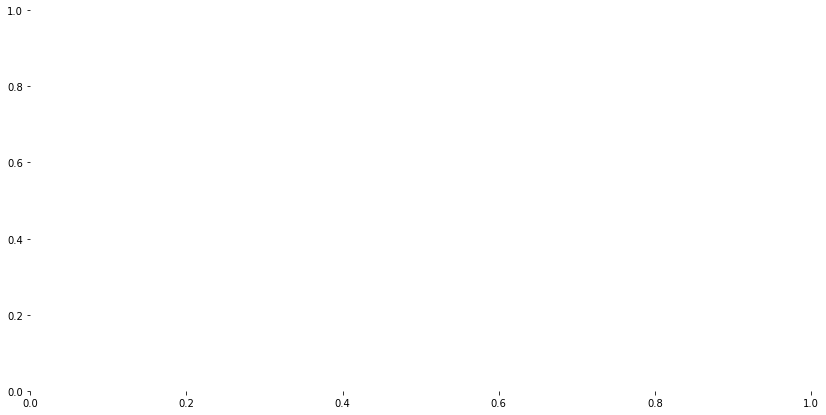

In [25]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (14,7))
ax.set_frame_on(False)
ax.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
numWords = 30
arrows = []
succ_count = 0
cWords = []
for i, word in enumerate(targetWords):
    try:
        arrowW = addWord(word, ax, 25, .9)
    except KeyError:
        pass
    else:
        succ_count += 1
        cWords.append(word)
    for a in arrowW:
        arrows.append(a)
    if succ_count > 10:
        break
    
#plt.xlim([0,20])
#plt.ylim([40,60])
plt.xticks(())
plt.yticks(())
ax.legend(arrows, ['To After', 'To Before', 'To Reddit'], fontsize = 20)
ax.set_title("Movement from Google word2vec to Gab word2vecs for words near 'Jews'", size = 20)
fig.tight_layout()
plt.savefig("tsen_jewish_arrows.pdf", format = 'pdf')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (14,7))
wordsims([w2v_google, before_aligned, after_aligned, reddit_aligned], cWords).plot.bar(ax = ax)

ax.legend(loc="lower right", fontsize = 20)
ax.set_title("Cosine distance of words near 'jew' from Google Word2vec", size = 20)
ax.tick_params('x', which='both',labelsize=24, rotation=45)
ax.set_ylabel("Cosine distance", size = 20)
fig.tight_layout()
plt.savefig("sim_bars_jewish.pdf", format = 'pdf')
plt.show()

In [312]:
len(many_aligned)

32

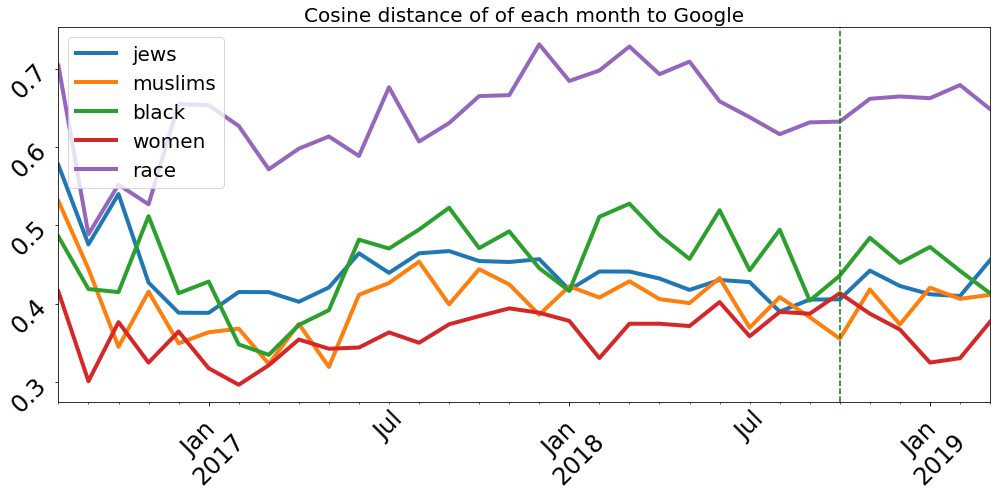

In [40]:
fig, ax = plt.subplots(figsize = (14,7))

l = sorted(many_aligned.items())

df_p = wordsims([w2v_google] + [v for k, v in l], ['jews','muslims', 'black', 'women', 'race'], names = [k.split('/')[-1][:7] for k, v in l]).T#.plot.bar(ax = ax)
df_p.index = pandas.to_datetime(df_p.index)
df_p.plot(ax=ax, linewidth =4)
ax.legend(fontsize = 20)
ax.set_title("Cosine distance of of each month to Google", size = 20)
ax.tick_params('both', which='both',labelsize=24, rotation=45)
ax.axvline(x=shootingDate, color='G', linestyle='--')
fig.tight_layout()
plt.savefig("sim_ethnic_jewish.pdf", format = 'pdf')
plt.show()

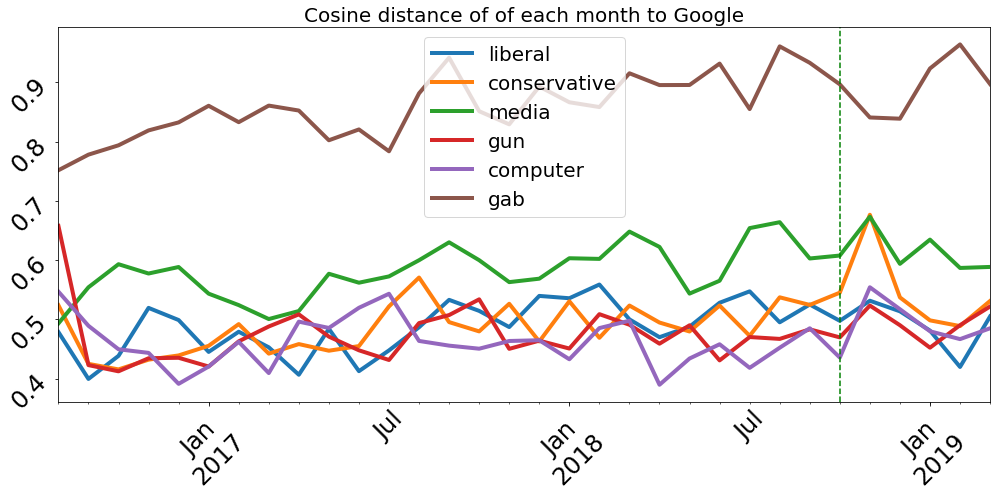

In [39]:
fig, ax = plt.subplots(figsize = (14,7))

l = sorted(many_aligned.items())

df_p = wordsims([w2v_google] + [v for k, v in l], ['liberal', 'conservative', 'media', 'gun', 'computer', 'ocasio', 'shoot', 'gab'], names = [k.split('/')[-1][:7] for k, v in l], drop_missing = True).T#.plot.bar(ax = ax)
df_p.index = pandas.to_datetime(df_p.index)
df_p.plot(ax=ax, linewidth =4)
ax.legend(fontsize = 20)
ax.set_title("Cosine distance of of each month to Google", size = 20)
ax.tick_params('both', which='both',labelsize=24, rotation=45)
ax.axvline(x=shootingDate, color='G', linestyle='--')
fig.tight_layout()
plt.savefig("sim_misc_jewish.pdf", format = 'pdf')
plt.show()

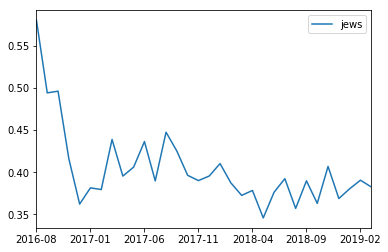

In [ ]:
def wordDists(w2vs, word):
    ret = []
    for wv in w2vs[1:]:
        try:
            for wv in w2vs[1:]:
                word_dat.append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(w2vs[0][word.title()].reshape(1, -1),
                                                                                 wv[word].reshape(1, -1))[0,0]))
        except KeyError:
            try:
                for wv in w2vs[1:]:
                    word_dat.append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(w2vs[0][word].reshape(1, -1),
                                                                                     wv[word].reshape(1, -1))[0,0]))
            except KeyError:
                pass
            else:
                ret.append(word_dat)
                index_vals.append(word)
        else:
            ret.append(word_dat)
            index_vals.append(word)
    return pandas.DataFrame(ret, columns=names, index = index_vals)

In [264]:
len(w2v_google.vocab)

3000000

In [24]:
def compareModels(embeddings_raw, sort = True):
    """If you are using time as your category sorting is important"""
    cats = sorted(embeddings_raw.keys())
    embeddings_aligned = {}
    for catOuter in cats:
        print(catOuter)
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_aligned

In [36]:
aligneds = compareModels(dict([('before', w2v_before),('after', w2v_after),('google', w2v_google)]))

after
before
google


In [42]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = list(embeddingsDict.keys())
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0][word].reshape(1, -1),
                                                                             embed[word].reshape(1, -1))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [43]:
#aligneds = {k.split('/')[-1].split('_')[0][:-3] : v for k, v in aligneds.items()}

In [44]:
aligneds

{'after': [<gensim.models.word2vec.Word2Vec at 0x7f07bdf41710>,
 'before': [<gensim.models.word2vec.Word2Vec at 0x7f07bdf417b8>,
 'google': [<gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7f07bdf410f0>,
  <gensim.models.keyedvectors.Word2VecKeyedVectors at 0x7f073becc9b0>]}

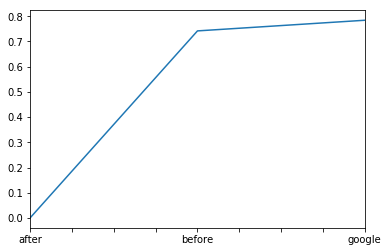

In [211]:
targetWord = 'jew'

pltDF = getDivergenceDF(targetWord, aligneds)
pltDF['after'].plot()

In [59]:
w2v_after.wv.similar_by_word('jews')

[('kikes', 0.7033160924911499),
 ('whites', 0.6893656253814697),
 ('rabbis', 0.6395903825759888),
 ('christians', 0.6246417760848999),
 ('muslims', 0.6238585710525513),
 ('zionists', 0.6117838621139526),
 ('#jews', 0.6048429608345032),
 ('pagans', 0.5957988500595093),
 ('arabs', 0.5944910645484924),
 ('blacks', 0.5911752581596375)]

In [60]:
w2v_before.wv.similar_by_word('jews')

[('kikes', 0.7360057830810547),
 ('#jews', 0.7074459791183472),
 ('whites', 0.7051321268081665),
 ('christians', 0.7011467218399048),
 ('muslims', 0.6826200485229492),
 ('arabs', 0.678466796875),
 ('zionists', 0.6760647296905518),
 ('germans', 0.6623551845550537),
 ('europeans', 0.6225511431694031),
 ('blacks', 0.6197293400764465)]

In [55]:
[w for w, s in w2v_after.wv.similar_by_word('jews', topn=100) if w in selectwords]

['saying',
 'gracious',
 'steal',
 'ric',
 'fun',
 'all',
 'tripod',
 'tosses',
 'cockpit',
 'this',
 'refuge',
 'bourgeois',
 'cretins',
 'inconsiderate',
 'dragon',
 'faker',
 'reread',
 'conniving',
 'girl',
 'g1',
 'deductions',
 'forgery',
 'infinitum',
 'lettering',
 'empress',
 'comcast',
 'ack',
 'naked',
 'vibes',
 'dunno',
 'stashed',
 'programming',
 'finalized',
 'tron',
 'quickly',
 'war',
 'gina',
 'swallowed',
 'gerade',
 'airmen',
 'slash',
 'smell',
 'an',
 'humanity',
 'beheads',
 'faculty',
 'muslim',
 'demanded',
 'wrench',
 'due',
 'eddy',
 'embeds',
 'mayer',
 'gook',
 'punctuation',
 'blasted',
 'in',
 'cad',
 'are',
 'organic',
 'auditing',
 'citizens']

In [53]:
[w for w, s in w2v_before.wv.similar_by_word('jew', topn=100) if w in selectwords]

['bolts',
 'targeting',
 'damages',
 'faceless',
 'herring',
 'destinations',
 'energize',
 'sidewalks',
 'illustration',
 'greenpeace',
 'frank',
 'bugged',
 'halle',
 'respectfully',
 'spur',
 'seit',
 'oils',
 'unclassified',
 'reminding',
 'esteemed',
 'payment',
 'begotten',
 'place',
 'burdens',
 'americans',
 'utter',
 'storming',
 'polluted',
 'presumption',
 'wear',
 'goddamned',
 'realms',
 'compromises',
 'disillusioned',
 'thwarting',
 'slots',
 'punishing',
 'shawn',
 'downloads',
 'yvonne',
 'incorporate',
 'stale',
 'birthdays',
 'tolerate',
 'going',
 'insect',
 'authoritarianism',
 'weakest',
 'reopens',
 'reeling',
 'elsewhere',
 'believers',
 'fuming',
 'dedicate']

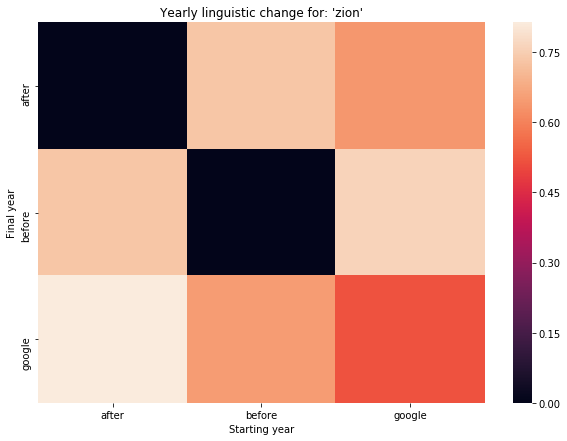

In [46]:
targetWord = 'zion'

pltDF = getDivergenceDF(targetWord, aligneds)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [61]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cats[0]][0][word].reshape(-1, 1), embed[word].reshape(-1, 1))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)

In [62]:
wordDivergences = findMostDivergent(aligneds)

Found 1314 words to compare


In [66]:
wordDivergences[-19:]

[('works', 16.0),
 ('m', 16.0),
 ('hitler', 16.0),
 ('america', 16.0),
 ('done', 16.0),
 ('question', 16.0),
 ('believe', 16.0),
 ('saw', 16.0),
 ('in', 16.0),
 ('@support', 16.0),
 ('porn', 16.0),
 ('much', 14.0),
 ('line', 14.0),
 ('face', 14.0),
 ('usa', 12.0),
 ('happen', 12.0),
 ('top', 12.0),
 ('die', 12.0),
 ('hell', 10.0)]

In [27]:
def compareModels(embeddings_raw, sort = True):
    """If you are using time as your category sorting is important"""
    #These are much quicker
    embeddings_aligned = {}
    cats = sorted(embeddings_raw.keys())
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter].wv]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner].wv))
    return embeddings_raw, embeddings_aligned

In [28]:
aligned_dict = compareModels(many_w2v)

In [31]:
embeddings_raw, embeddings_aligned = aligned_dict

In [36]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(embeddingsDict[cat][0][word].reshape(-1,1),
                                                                             embed[word].reshape(-1,1))[0,0]))
    return pandas.DataFrame(dists, index = cats)

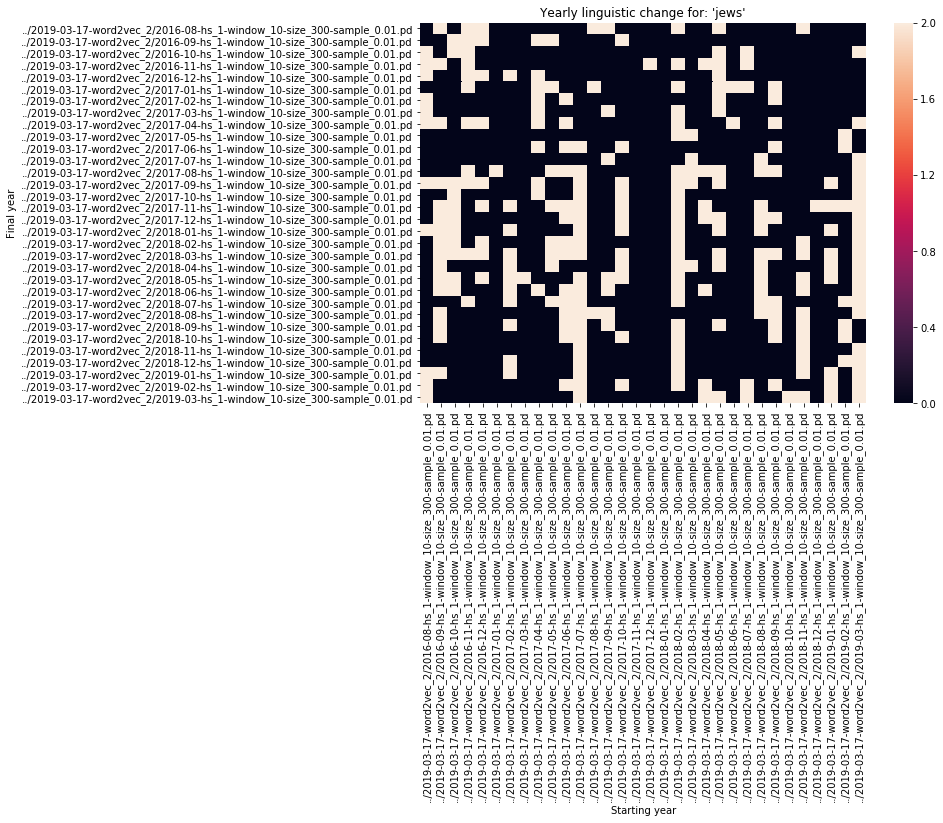

In [37]:
targetWord = 'jews'

pltDF = getDivergenceDF(targetWord, embeddings_aligned)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()